In [3]:
import cv2
import torch
from torch import nn
from torchvision import transforms

In [4]:
INPUT_WIDTH = 224

In [5]:
normalise = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225]) 

In [6]:
def preprocess(np_image_bgr):
    '''
    Preprocessing for embedder network: Flips BGR to RGB, resize, convert to torch tensor, normalise with imagenet mean and variance, reshape. Note: input image yet to be loaded to GPU through tensor.cuda()

    Parameters
    ----------
    np_image_bgr : ndarray
        (H x W x C) in BGR

    Returns
    -------
    Torch Tensor

    '''
    np_image_rgb = np_image_bgr[...,::-1]
    np_image_rgb = cv2.resize(np_image_rgb, (INPUT_WIDTH, INPUT_WIDTH))
    input_image = transforms.ToTensor()(np_image_rgb)
    input_image = normalise(input_image) 
#     input_image = input_image.view(1,3,INPUT_WIDTH,INPUT_WIDTH)
    return input_image

In [7]:
from torch import nn
from pathlib import Path
import torchvision.models as models

class Resnet_Embedder(object):
    '''
    Resnet_Embedder loads a resnet pretrained on Imagenet1000, with classification layer removed, exposing the bottleneck layer, outputing a feature of size 1280. 
    '''
    def __init__(self, model_wts_path = None, depth=50, bs=8):
        if model_wts_path is None:
            pretrained=True
        else:
            pretrained=False
            assert Path(model_wts_path).is_file(),'Model path does not exists!'
            
        if depth == 18:
            full_model = models.resnet18(pretrained=pretrained)
        elif depth == 50:
            full_model = models.resnet50(pretrained=pretrained)
        elif depth == 101:
            full_model = models.resnet101(pretrained=pretrained)
        else:
            assert True,'Resnet with specified depth {} does not exist!'.format(depth)

        with torch.no_grad():
            self.model = nn.Sequential(*list(full_model.children())[:-1])
            del full_model
        self.model.cuda() #loads model to gpu
        self.model.eval() #inference mode, deactivates dropout layers 
        print('Resnet{} Embedder initialised!'.format(depth))
        self.bs = bs
        self.model.forward(torch.zeros(self.bs, 3, INPUT_WIDTH, INPUT_WIDTH).cuda()) #warmup

    def preprocess(self, np_image_bgr):
        '''
        Preprocessing for embedder network: Flips BGR to RGB, resize, convert to torch tensor, normalise with imagenet mean and variance, reshape. Note: input image yet to be loaded to GPU through tensor.cuda()

        Parameters
        ----------
        np_image_bgr : ndarray
            (H x W x C) in BGR

        Returns
        -------
        Torch Tensor

        '''
        np_image_rgb = np_image_bgr[...,::-1]
        np_image_rgb = cv2.resize(np_image_rgb, (INPUT_WIDTH, INPUT_WIDTH))
        input_image = transforms.ToTensor()(np_image_rgb)
        input_image = normalise(input_image) 
#         input_image = input_image.view(1,3,INPUT_WIDTH,INPUT_WIDTH)
        return input_image

    def forward(self, batch_tensor):
        feats = self.model.forward(batch_tensor.cuda())
        return feats.cpu().data.numpy()
    
    def predict(self, np_image_bgr):
        '''
        singly inference

        Params
        ------
        np_image_bgr : ndarray
            list of (H x W x C) in BGR
        
        Returns
        ------
        features (np.array)

        '''
        input_img = self.preprocess(np_image_bgr).cuda()
        feats = self.model.forward(input_img)
        return feats[0].cpu().data.numpy().flatten()

    def predict_batch(self, list_of_np_image_bgr):
        '''
        singly inference

        Params
        ------
        list_of_np_image_bgr : list of ndarray
            list of (N x H x W x C) in BGR
        
        Returns
        ------
        list of features (np.array with dim = 1280)

        '''
        
        for i in range(0, len(list_of_np_image_bgr), self.bs):
            in_batch = preprocess(list_of_np_image_bgr[i:i+self.bs])
            res = self.model.forward(in_batch)
        
        input_img = self.preprocess(np_image_bgr).cuda()
        feats = self.model.forward(input_img)
        return feats[0].cpu().data.numpy().flatten()
    
    

In [40]:
import cv2
from pathlib import Path
from torch.utils.data import Dataset, DataLoader

class IndoorDataset(Dataset):
    """Indoor Scene dataset."""

    def __init__(self, root_dir, preproc=None):
        """
        Args:
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        assert Path(root_dir).is_dir()
        self.impaths = []
        for ext in ['jpg','png','jpeg']:
            self.impaths.extend(Path(root_dir).glob('*.{}'.format(ext)))
        self.preproc = preproc

    def __len__(self):
        return len(self.impaths)

    def __getitem__(self, idx):
        impath = self.impaths[idx]
        X = cv2.imread(str(impath))
        if self.preproc:
            X = self.preproc(X)
        y = '_'.join(impath.stem.split('_')[:2])

        return X, y, str(impath)


In [41]:
resmodel = Resnet_Embedder(depth=50)

Resnet50 Embedder initialised!


In [42]:
preproc = resmodel.preprocess
# preproc = None
indoorDataset = IndoorDataset('/media/dh/HDD1/roomid/dsta_indoor', preproc=preproc)

In [11]:
# import matplotlib.pyplot as plt
# X, y = indoorDataset[10]
# imgplot = plt.imshow(X)
# print(y)
# plt.show()

In [43]:
dataloader = DataLoader(indoorDataset, batch_size=4, shuffle=False, num_workers=4)

In [44]:
embedding_pairs = []
for i, Xyp in enumerate(dataloader):
    X, y, ips = Xyp
    embs = resmodel.forward(X)
    for i, label in enumerate(y):
        embedding_pairs.append((label, embs[i,].flatten(), ips[i]))

In [45]:
len(embedding_pairs)

78

In [46]:
embedding_pairs = sorted(embedding_pairs, key=lambda x : x[0])

In [47]:
labels_only = [pair[0] for pair in embedding_pairs]

In [48]:
import string
abc = string.ascii_uppercase
label2abc = {}
for i, label in enumerate(sorted(list(set(labels_only)))):
    label2abc[label] = abc[i]
label2abc

{'Ak_1': 'A',
 'Akash_1': 'B',
 'Akash_2': 'C',
 'Akash_3': 'D',
 'Akash_4': 'E',
 'Akash_5': 'F',
 'Akash_6': 'G',
 'AstridLew_1': 'H',
 'AstridLew_2': 'I',
 'AstridLew_3': 'J',
 'AstridLew_4': 'K',
 'Evan_1': 'L',
 'Evan_2': 'M',
 'Evan_3': 'N',
 'JaneS_1': 'O',
 'JaneS_2': 'P',
 'LeslieLim_1': 'Q',
 'LeslieLim_2': 'R',
 'RenJie_1': 'S',
 'RenJie_2': 'T',
 'RenJie_3': 'U',
 'RenJie_4': 'V',
 'RenJie_5': 'W',
 'RenJie_6': 'X'}

In [49]:
new_labels = [label2abc[l] for l in labels_only]
# new_labels

In [50]:
embeddings_only = [pair[1] for pair in embedding_pairs]

In [51]:
impaths_only = [pair[-1] for pair in embedding_pairs]

In [19]:
from scipy.spatial import distance_matrix

In [52]:
dist_mat = distance_matrix(embeddings_only, embeddings_only)

In [53]:
dist_mat.shape

(78, 78)

In [115]:
import seaborn

In [116]:
import matplotlib.pyplot as plt
context = 'Resnet50-Imagenet'
plt.figure(figsize = (30,30))
# fig, ax = plt.subplots()
# fig.set_figheight=300
# fig.set_figwidth=300
heat_map = seaborn.heatmap(dist_mat, xticklabels=new_labels, yticklabels=new_labels, cmap=seaborn.color_palette("Blues"))
heat_map.xaxis.set_ticks_position('top')
heat_map.set_title('Distance Heatmap: {}'.format(context), fontsize=30)
heat_map.figure.savefig('dist_mat_{}.png'.format(context))

In [54]:
import numpy as np
def eval_at_thresh(labels, dist_matrix, thresh=10):
    threshed = np.where(dist_matrix < thresh, 0, 1)
    fmrs = []
    fnmrs = []
    for i, q_label in enumerate(labels):
        same_count = 0
        diff_count = 0
        fm_count = 0
        fnm_count = 0
        for j, this_label in enumerate(labels):
            if i == j:
                continue
            pred_diff = threshed[i,j]
            if q_label == this_label:
                same_count += 1
                if pred_diff:
                    fnm_count += 1
            else:
                diff_count += 1
                if not pred_diff:
                    fm_count += 1
        fmr = fm_count / diff_count
        fnmr = fnm_count / same_count
#         print("Query: {}".format(q_label))
#         print("\t - False Match Rate: {}".format(fmr))
#         print("\t - False Non-Match Rate: {}".format(fnmr))
        fmrs.append(fmr)
        fnmrs.append(fnmr)
    mean_fmr = np.mean(fmrs)
    mean_fnmr = np.mean(fnmrs)
#     print('Mean FMR: {}'.format(mean_fmr))
#     print('Mean FNMR: {}'.format(mean_fnmr))
    return mean_fmr, mean_fnmr, fmrs, fnmrs

In [55]:
threshes = range(0, 30, 1)
mean_fmrs = []
mean_fnmrs = []
for thresh in threshes:
    mean_fmr, mean_fnmr, _, _ = eval_at_thresh(labels_only, dist_mat, thresh=thresh)
    mean_fmrs.append(mean_fmr)
    mean_fnmrs.append(mean_fnmr)
#     print('THRESH: {}'.format(thresh))
#     print('\tMean FMR: {}'.format(mean_fmr))
#     print('\tMean FNMR: {}'.format(mean_fnmr))

### Resnet 101

In [25]:
resmodel = Resnet_Embedder(depth=101)

Resnet101 Embedder initialised!


In [26]:
rn101_embedding_pairs = []
for i, Xy in enumerate(dataloader):
    X, y = Xy
    embs = resmodel.forward(X)
    for i, label in enumerate(y):
        rn101_embedding_pairs.append((label, embs[i,].flatten()))

In [27]:
rn101_embedding_pairs = sorted(rn101_embedding_pairs, key=lambda x : x[0])
rn101_labels_only = [pair[0] for pair in rn101_embedding_pairs]
rn101_new_labels = [label2abc[l] for l in rn101_labels_only]
rn101_embeddings_only = [pair[1] for pair in rn101_embedding_pairs]
len(rn101_new_labels)

78

In [28]:
rn101_dist_mat = distance_matrix(rn101_embeddings_only, rn101_embeddings_only)
rn101_dist_mat.shape

(78, 78)

In [123]:
import matplotlib.pyplot as plt
context = 'Resnet101-Imagenet'
plt.figure(figsize = (30,30))
heat_map = seaborn.heatmap(rn101_dist_mat, xticklabels=new_labels, yticklabels=new_labels, cmap=seaborn.color_palette("Blues"))
heat_map.xaxis.set_ticks_position('top')
heat_map.set_title('Distance Heatmap: {}'.format(context), fontsize=30)
heat_map.figure.savefig('dist_mat_{}.png'.format(context))

In [29]:
rn101_threshes = range(0, 30, 1)
rn101_mean_fmrs = []
rn101_mean_fnmrs = []
for thresh in rn101_threshes:
    mean_fmr, mean_fnmr, _, _ = eval_at_thresh(rn101_labels_only, rn101_dist_mat, thresh=thresh)
    rn101_mean_fmrs.append(mean_fmr)
    rn101_mean_fnmrs.append(mean_fnmr)

### Resnet 18

In [30]:
resmodel = Resnet_Embedder(depth=18)

Resnet18 Embedder initialised!


In [31]:
rn18_embedding_pairs = []
for i, Xy in enumerate(dataloader):
    X, y = Xy
    embs = resmodel.forward(X)
    for i, label in enumerate(y):
        rn18_embedding_pairs.append((label, embs[i,].flatten()))

In [32]:
rn18_embedding_pairs = sorted(rn18_embedding_pairs, key=lambda x : x[0])
rn18_labels_only = [pair[0] for pair in rn18_embedding_pairs]
rn18_new_labels = [label2abc[l] for l in rn18_labels_only]
rn18_embeddings_only = [pair[1] for pair in rn18_embedding_pairs]
len(rn18_new_labels)

78

In [33]:
rn18_dist_mat = distance_matrix(rn18_embeddings_only, rn18_embeddings_only)
rn18_dist_mat.shape

(78, 78)

In [131]:
import matplotlib.pyplot as plt
context = 'Resnet18-Imagenet'
plt.figure(figsize = (30,30))
heat_map = seaborn.heatmap(rn18_dist_mat, xticklabels=new_labels, yticklabels=new_labels, cmap=seaborn.color_palette("Blues"))
heat_map.xaxis.set_ticks_position('top')
heat_map.set_title('Distance Heatmap: {}'.format(context), fontsize=30)
heat_map.figure.savefig('dist_mat_{}.png'.format(context))

In [34]:
rn18_threshes = range(0, 30, 1)
rn18_mean_fmrs = []
rn18_mean_fnmrs = []
for thresh in rn18_threshes:
    mean_fmr, mean_fnmr, _, _ = eval_at_thresh(rn18_labels_only, rn18_dist_mat, thresh=thresh)
    rn18_mean_fmrs.append(mean_fmr)
    rn18_mean_fnmrs.append(mean_fnmr)

## For TSNE Viz

In [39]:
fpath = '/media/dh/HDD1/roomid/embeddings/resnet50_embs.csv'
np.savetxt(fpath, np.array(embeddings_only) )

In [60]:
tsne_label_path = '/media/dh/HDD1/roomid/tsne/labels_img.txt'
with open(tsne_label_path,'w') as f:
    f.write('label\timage\n')
    for label, impath in zip(labels_only, impaths_only): 
        f.write('{}\t{}\n'.format(label, Path(impath).name))

## Person REID

In [87]:
import torch
import torchvision.transforms as transforms
import torchvision.models as models
import torchvision.transforms.functional as functional
import torch.nn as nn
from torch.autograd import Variable
from PIL import Image
import numpy as np
import glob, os
import argparse
import types
import time 
import pickle
import cv2
# from scipy.misc import imresize

class REID_embed(object):
    def __init__(self):
        print('Initialising embedder..')
        self.model = self.TripletNetBasic()
#         cur_dir = os.path.dirname(os.path.abspath(__file__))
        cur_dir = '.'
        weights = os.path.join(cur_dir, 'bestmodel_checkpoint_py3.pth.tar')   #pre-trained model file
        checkpoint = torch.load(weights, map_location=lambda storage, location: storage.cuda(0)) #loading parameters of pre-trained model
        # checkpoint = torch.load(weights, map_location=lambda storage, location: storage) #loading parameters of pre-trained model
        self.model.load_state_dict(checkpoint['state_dict'])
        self.model.eval() #Switch the model to evaluation mode. Very important!!! Must do before use
        self.model.cuda() #Use GPU

    #-------------------neural network definition-----------------------------
    #---------Rose Re-id backend API adopts Resnet50 as backbone--------------
    class ResNetBasic(nn.Module):
        def __init__(self):
            super(REID_embed.ResNetBasic, self).__init__()
            self.resnet = models.resnet50()
            # print self.resnet._modules.keys()
            def resnet_forward(resnet,x):
                x = resnet.conv1(x)
                x = resnet.bn1(x)
                x = resnet.relu(x)
                x = resnet.maxpool(x)
                x = resnet.layer1(x)
                x = resnet.layer2(x)
                x = resnet.layer3(x)
                x = resnet.layer4(x)
                return x
            self.resnet.avgpool = None
            self.resnet.fc = None
            self.resnet.forward = types.MethodType(resnet_forward, self.resnet)
            self.avgp1 = nn.AvgPool2d((8,4))
            self.fc1 = nn.Linear(2048, 1024)
            self.bn1 = nn.BatchNorm1d(1024)
            self.relu1 = nn.ReLU()
            self.fc2 = nn.Linear(1024,128)

        def forward(self, x):
            x = self.resnet(x)
            x = self.avgp1(x).view(-1,2048)
            x = self.fc1(x)
            x = self.bn1(x)
            x = self.relu1(x)
            x = self.fc2(x)
            return x

    #-------------------Inference network definition---------------------------
    class TripletNetBasic(nn.Module):
        def __init__(self):
            super(REID_embed.TripletNetBasic, self).__init__()
            self.feat_extraction = REID_embed.ResNetBasic()
            self.fc = nn.Linear(128, 751)
            self.matching = nn.PairwiseDistance(2)

        def forward(self, a):
            a1 = self.feat_extraction(a)        
            return a1 

    def forward(self, batch_tensor):
        feats = self.model.forward(batch_tensor.cuda())
        return feats.cpu().data.numpy()

In [88]:
reid_embedder = REID_embed()

Initialising embedder..


In [98]:
def reid_preprocess(np_image_bgr):
    '''
    Preprocessing for embedder network: Flips BGR to RGB, resize, convert to torch tensor, normalise with imagenet mean and variance, reshape. Note: input image yet to be loaded to GPU through tensor.cuda()

    Parameters
    ----------
    np_image_bgr : ndarray
        (H x W x C) in BGR

    Returns
    -------
    Torch Tensor

    '''
    np_image_rgb = np_image_bgr[...,::-1]
    np_image_rgb = cv2.resize(np_image_rgb, (128, 256))
    input_image = transforms.ToTensor()(np_image_rgb)
    input_image = normalise(input_image) 
    return input_image

reid_indoorDataset = IndoorDataset('/media/dh/HDD1/roomid/dsta_indoor', preproc=reid_preprocess)
reid_dataloader = DataLoader(reid_indoorDataset, batch_size=4, shuffle=False, num_workers=4)

In [106]:
reid_rn50_embedding_pairs = []
for i, Xyp in enumerate(dataloader):
    X, y, ips = Xyp
    embs = reid_embedder.forward(X)
#     import pdb; pdb.set_trace()
    for i, label in enumerate(y):
        reid_rn50_embedding_pairs.append((label, embs[i,].flatten(), ips[i]))

In [107]:
len(reid_rn50_embedding_pairs)

78

In [108]:
reid_rn50_embedding_pairs = sorted(reid_rn50_embedding_pairs, key=lambda x : x[0])
reid_rn50_labels_only = [pair[0] for pair in reid_rn50_embedding_pairs]
reid_rn50_new_labels = [label2abc[l] for l in reid_rn50_labels_only]
reid_rn50_embeddings_only = [pair[1] for pair in reid_rn50_embedding_pairs]
len(reid_rn50_new_labels)

78

In [109]:
reid_rn50_dist_mat = distance_matrix(reid_rn50_embeddings_only, reid_rn50_embeddings_only)
reid_rn50_dist_mat.shape

(78, 78)

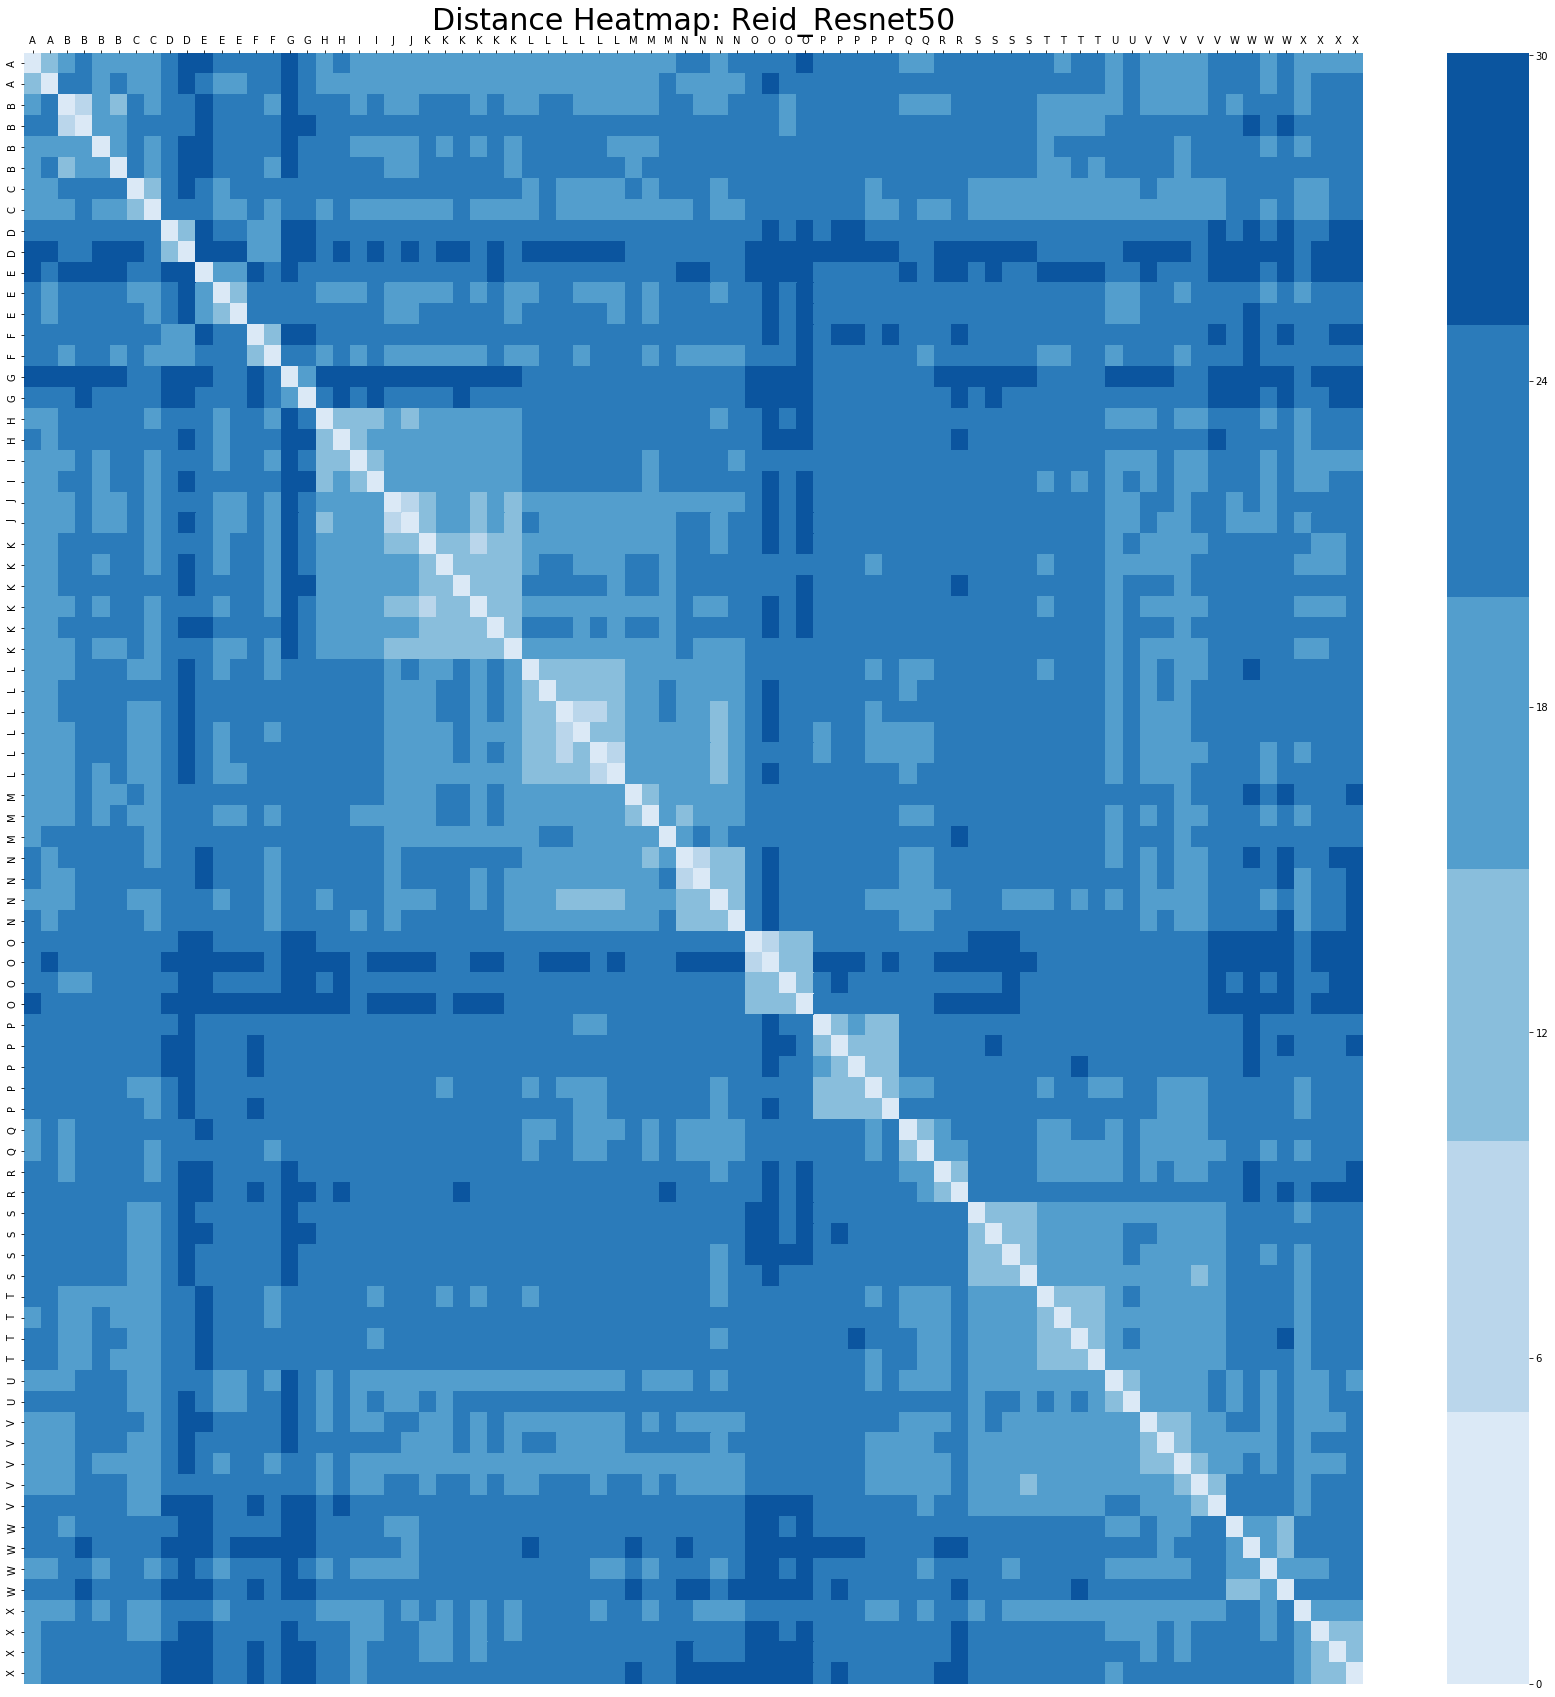

In [110]:
import seaborn
import matplotlib.pyplot as plt
context = 'Reid_Resnet50'
plt.figure(figsize = (30,30))
heat_map = seaborn.heatmap(rn18_dist_mat, xticklabels=new_labels, yticklabels=new_labels, cmap=seaborn.color_palette("Blues"))
heat_map.xaxis.set_ticks_position('top')
heat_map.set_title('Distance Heatmap: {}'.format(context), fontsize=30)
heat_map.figure.savefig('dist_mat_{}.png'.format(context))

In [111]:
reid_rn50_mean_fmrs_rectpreproc = reid_rn50_mean_fmrs
reid_rn50_mean_fnmrs_rectpreproc = reid_rn50_mean_fnmrs

In [112]:
reid_rn50_threshes = range(0, 30, 1)
reid_rn50_mean_fmrs = []
reid_rn50_mean_fnmrs = []
for thresh in reid_rn50_threshes:
    mean_fmr, mean_fnmr, _, _ = eval_at_thresh(reid_rn50_labels_only, reid_rn50_dist_mat, thresh=thresh)
    reid_rn50_mean_fmrs.append(mean_fmr)
    reid_rn50_mean_fnmrs.append(mean_fnmr)

In [113]:
import plotly.graph_objects as go

fig = go.Figure()



resnet18_trace = go.Scatter(x=np.array(rn18_mean_fnmrs),
                            y=np.array(rn18_mean_fmrs),
                            name='Resnet18-Imagenet')

resnet50_trace = go.Scatter(x=np.array(mean_fnmrs),
                            y=np.array(mean_fmrs),
                            name='Resnet50-Imagenet')

resnet101_trace = go.Scatter(x=np.array(rn101_mean_fnmrs),
                             y=np.array(rn101_mean_fmrs),
                            name='Resnet101-Imagenet')

reid_resnet50_rectpreproc_trace = go.Scatter(x=np.array(reid_rn50_mean_fnmrs_rectpreproc),
                             y=np.array(reid_rn50_mean_fmrs_rectpreproc),
                            name='Reid-Resnet50_rectpreproc')

reid_resnet50_trace = go.Scatter(x=np.array(reid_rn50_mean_fnmrs),
                             y=np.array(reid_rn50_mean_fmrs),
                            name='Reid-Resnet50')


perfect_trace = go.Scatter(x=np.array([0, 0, 1]),
                           y=np.array([1, 0, 0]),
                           name='Perfect',
                           mode='lines',
                            marker=dict(
                                color='rgba(0, 0, 0, 0.75)',
                                size=10,
                                line=dict(
#                                     color='MediumPurple',
                                    width=1
                                )
                            ),
                          )
                           


fig.add_trace(resnet18_trace)
fig.add_trace(resnet50_trace)
fig.add_trace(resnet101_trace)
fig.add_trace(reid_resnet50_rectpreproc_trace)
fig.add_trace(reid_resnet50_trace)
fig.add_trace(perfect_trace)

fig.update_layout(
    title={'text': "Indoor Scene Matching on 78 indoor scenes",
           'x': 0.5,
           'xanchor': 'center'},
    xaxis_title="False Non-Match Rate",
    yaxis_title="False Match Rate",
    font=dict(
        family="Courier New, monospace",
        size=12,
        color="#7f7f7f"
    )
)

fig.show()